<a href="https://colab.research.google.com/github/Arcus0800/repo1/blob/main/HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Imports
import torch
import random
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [45]:
#Hyperparameters
batch_size = 64
learning_rate = 5e-5
epochs = 1000

DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

In [8]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head(10)

Using downloaded and verified file: ./BostonHousing.csv


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


In [7]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape
inputs = torch.from_numpy(inputs).float()
targets = torch.from_numpy(targets).float()
ds = TensorDataset(inputs,targets)
train_ds, val_ds = random_split(ds, [406,100])
train_ldr = DataLoader(train_ds, batch_size, shuffle=True)  #divides the data in batches like [batch1, batch2, batch3, ...]
val_ldr = DataLoader(val_ds, batch_size*2)

In [11]:
class pricepred(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self,x):
        return self.linear(x)

    def train_step(self, batch):
        inputs, targets = batch
        pred = self(inputs)
        loss = F.mse_loss(pred, targets)
        return loss

    def val_step(self, batch):
        inputs, targets = batch
        pred = self(inputs)
        loss = F.mse_loss(pred, targets)
        return {'val_loss': loss.detach()}

    def val_epoch_end(self, output):
        batch_loss = [x['val_loss'] for x in output]
        epoch_loss = torch.stack(batch_loss).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

model = pricepred()

def evalt(model, val_ldr):
    outputs = [model.val_step(batch) for batch in val_ldr]
    return model.val_epoch_end(outputs)

opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
def train(epochs, lr, model, train_ldr, val_ldr):
    history = []
    for i in range(epochs):
        #training
        for batch in train_ldr:   #takes 1 batch at a time to calculate loss and optimize it
            opt.zero_grad()
            loss = model.train_step(batch)
            loss.backward()
            opt.step()
        #validation
        res = evalt(model, val_ldr)
        model.epoch_end(i, res)
        history.append(res)
    return history


Epoch [0], val_loss: 89.9408
Epoch [1], val_loss: 89.9501
Epoch [2], val_loss: 90.6378
Epoch [3], val_loss: 90.9587
Epoch [4], val_loss: 89.8955
Epoch [5], val_loss: 90.1872
Epoch [6], val_loss: 91.0767
Epoch [7], val_loss: 89.9568
Epoch [8], val_loss: 90.3770
Epoch [9], val_loss: 90.4352
Epoch [10], val_loss: 89.8645
Epoch [11], val_loss: 89.6833
Epoch [12], val_loss: 90.4931
Epoch [13], val_loss: 90.0034
Epoch [14], val_loss: 90.9166
Epoch [15], val_loss: 89.7614
Epoch [16], val_loss: 89.6214
Epoch [17], val_loss: 89.8231
Epoch [18], val_loss: 90.0254
Epoch [19], val_loss: 90.1516
Epoch [20], val_loss: 90.6255
Epoch [21], val_loss: 89.9631
Epoch [22], val_loss: 89.9614
Epoch [23], val_loss: 89.6946
Epoch [24], val_loss: 89.8059
Epoch [25], val_loss: 89.6420
Epoch [26], val_loss: 92.9320
Epoch [27], val_loss: 90.2675
Epoch [28], val_loss: 89.4090
Epoch [29], val_loss: 89.6497
Epoch [30], val_loss: 89.6665
Epoch [31], val_loss: 89.3157
Epoch [32], val_loss: 89.6007
Epoch [33], val_loss

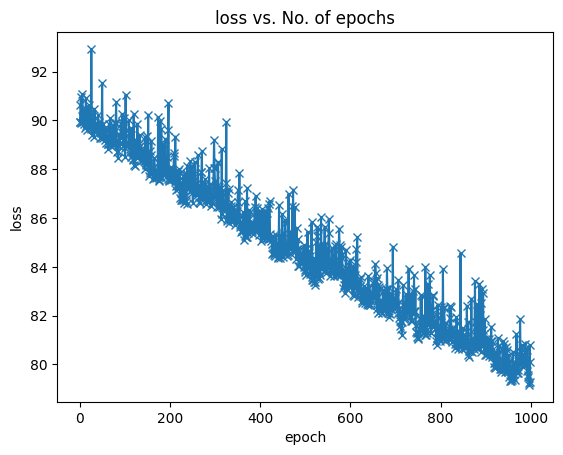

In [46]:
history = train(epochs, learning_rate, model, train_ldr, val_ldr)
loss = [r['val_loss'] for r in history]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs. No. of epochs');

In [47]:
torch.save(model.state_dict(), 'pricepred.pth')

In [54]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()
x, target = val_ds[random.randint(0,99)]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.7505e-01, 0.0000e+00, 5.9600e+00, 0.0000e+00, 4.9900e-01, 5.9660e+00,
        3.0200e+01, 3.8473e+00, 5.0000e+00, 2.7900e+02, 1.9200e+01, 3.9343e+02,
        1.0130e+01])
Target:  24.700000762939453
Prediction: 21.006027221679688
